<a href="https://colab.research.google.com/github/pipoomm/topologyzoo/blob/main/mumu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import math
import random
import networkx as nx

import requests
from io import StringIO, BytesIO
import traceback
import copy

import matplotlib.pyplot as plt
from tabulate import tabulate

## Preparing graph

###From k-random graph

In [ ]:
def read_json_city_from_url(url):
  # Fetch JSON city list data from the URL
  response = requests.get(url)

  # Check if the request was successful
  if response.status_code == 200:
      # Convert JSON data to a Python list
      city_list = response.json()
  else:
      print(f"Error fetching data: {response.status_code}")

  return city_list

In [ ]:
# Parameters for the random k-regular graph
k = 10   # Degree of each node
n = 300  # Number of nodes in the graph

# Generate a random k-regular graph
G = nx.random_regular_graph(k, n)

# Covert to graph with string node labels
G = nx.relabel_nodes(G, {node: str(node) for node in G.nodes})

In [ ]:
# Add city information to node attributes
url = "https://raw.githubusercontent.com/pipoomm/topologyzoo/main/airports_citylist.json"
city_list = read_json_city_from_url(url)

node_attributes = {}
seed_value = 610615011
used_numbers = set() # set to keep track of used random_number values

for i, node in enumerate(G.nodes):
    random.seed(seed_value)
    random_number = random.randint(0, 8866)
    
    # check if random_number has already been used, generate a new one if it has
    while random_number in used_numbers:
        random_number = random.randint(0, 8866)
        
    # add random_number to used_numbers set
    used_numbers.add(random_number)

    node_attributes[str(node)] = {
        'Internal': 1,  
        'Latitude': city_list[random_number]['latitude_deg'],  
        'Country': city_list[random_number]['iso_country'],  
        'type': 'node',
        'id': int(node),
        'Longitude': city_list[random_number]['longitude_deg'], 
        'label': city_list[random_number]['iata_code']
    }
    seed_value *= 3

# Set node attributes
for node, attributes in node_attributes.items():
     for attr_key, attr_value in attributes.items():
         G.nodes[node][attr_key] = attr_value

###From The Internet Topology Zoo

In [2]:
def read_graphml_from_url(url):
    # Download the GraphML file
    response = requests.get(url)
    if response.status_code == 200:
        # Parse the GraphML content using NetworkX
        graphml_data = response.text
        graphml_file = StringIO(graphml_data)
        graph = nx.read_graphml(graphml_file)
        return graph
    else:
        raise Exception(f"Error downloading GraphML file. Status code: {response.status_code}")

In [3]:
# Topology dataset
att = "https://raw.githubusercontent.com/pipoomm/topologyzoo/main/AttMpls.graphml"      # (25 Nodes, 57 Edges)
geant = "https://raw.githubusercontent.com/pipoomm/topologyzoo/main/Geant2012.graphml"  # (37 Nodes, 58 Edges)

certnet = "https://raw.githubusercontent.com/pipoomm/topologyzoo/main/Cernet.graphml"   # Small network (37 Nodes, 55 Edges)
tw = "https://raw.githubusercontent.com/pipoomm/topologyzoo/main/Tw.graphml"            # Medium network (76 Nodes, 118 Edges)
colt = "https://raw.githubusercontent.com/pipoomm/topologyzoo/main/Colt.graphml"        # Large network (149 Node, 178 Edges)

# Load GraphML file
G = read_graphml_from_url(att)

In [4]:
# Remove nodes without 'Latitude' or 'Longitude' attributes
nodes_to_remove = [n for n, d in G.nodes(data=True) if 'Latitude' not in d or 'Longitude' not in d]
G.remove_nodes_from(nodes_to_remove)

# Remove isolated nodes
isolated_nodes = list(nx.isolates(G))
G.remove_nodes_from(isolated_nodes)

### Role assign and network topology virtualization

In [5]:
# Set the initial role of all nodes to "none"
roles = {}
for n in G.nodes():
    roles[n] = "none"

In [6]:
# target_controller_count = 3
amount_of_controller = 0
amount_of_switch = 0

# Repeatedly identify "controller" and "switch" nodes until all nodes are defined
while "none" in roles.values():
    # Select the node with the highest number of connected neighbors and no role assigned
    candidates = [n for n in G.nodes() if roles[n] == "none"]
    node_degrees = [(n, G.degree(n)) for n in candidates]
    node_degrees.sort(key=lambda x: (-x[1], x[0]))
    node_i = node_degrees[0][0]

    # If amount_of_controller is equal to target_controller_count, assign "switch" role to all remaining nodes without a role
    # if amount_of_controller == target_controller_count:
    #     for n in candidates:
    #         roles[n] = "switch"
    #         amount_of_switch += 1
    #     break

    # Assign the "controller" role to node i
    roles[node_i] = "controller"
    amount_of_controller += 1

    # Assign the "switch" role to all 1-hop connected nodes (neighbors) of node i with no role assigned
    for neighbor in G.neighbors(node_i):
        if roles[neighbor] == "none":
            roles[neighbor] = "switch"
            amount_of_switch += 1

# Set the role attribute for each node
nx.set_node_attributes(G, roles, "role")
print(f'Amount of controller: {amount_of_controller}\nAmount of switch: {amount_of_switch}\nTotal device: {amount_of_controller+amount_of_switch}')

Amount of controller: 8
Amount of switch: 17
Total device: 25


In [ ]:
num_edges = G.number_of_edges()
print("Number of edges in the graph:", num_edges)

In [ ]:
# Print the node roles
for n, r in nx.get_node_attributes(G, "role").items():
    print(f"Node {n} is a {r}")

In [ ]:
for n, data in G.nodes(data=True):
    print(f"Node {n}: {data}")

In [ ]:
[n for n in G.neighbors('0')]

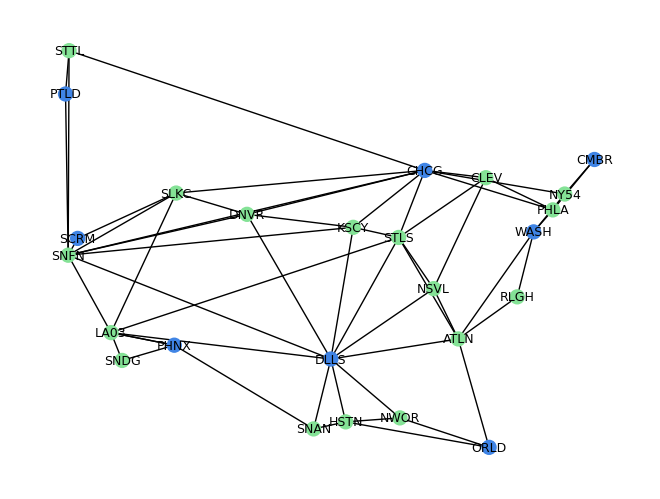

In [7]:
node_positions = {}
for node in G.nodes():
  label = G.nodes[node]['id']
  node_positions[node] = (G.nodes[node]['Longitude'], G.nodes[node]['Latitude'])

# Define node colors based on their roles (controller: blue, switch: green)
node_colors = {"controller": "#3f84e5", "switch": "#84e296"}

# Draw the graph with node colors
nx.draw(G, node_color=[node_colors[G.nodes[n]["role"]] for n in G.nodes()], pos=node_positions, labels={node: G.nodes[node]['label'] for node in G.nodes()},with_labels=True,node_size=100, font_size=9)

# Show the plot
plt.show()

## Stage 1 - Matching switch wth nearest controller

In [8]:
def haversine_distance(u, v):
    lat1, lon1 = G.nodes[u]['Latitude'], G.nodes[u]['Longitude']
    lat2, lon2 = G.nodes[v]['Latitude'], G.nodes[v]['Longitude']
    
    R = 6371  # Earth's radius in kilometers
    
    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    
    a = (math.sin(dlat / 2) * math.sin(dlat / 2) +
         math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
         math.sin(dlon / 2) * math.sin(dlon / 2))
    
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c
    return distance

In [9]:
# Step 4: Set `selected_con` attribute for switch nodes
def setSelectedCon():
  candidate_controllers = [n for n, d in G.nodes(data=True) if d['role'] == "controller"]
  global switch_to_controller_list
  switch_to_controller_list = [] 
  for node_id in G.nodes():
    if G.nodes[node_id]['role'] == 'switch':
      hop_counts = []
      for con in candidate_controllers:
        path = nx.astar_path(G, source=node_id, target=con, heuristic=haversine_distance)
        hop_count = len(path) - 1
        hop_counts.append([con, hop_count, 0])
      sorted_hops = sorted(hop_counts, key=lambda x: (x[1]), reverse=False)
      G.nodes[node_id]['selected_con'] = sorted_hops[0][0]
      switch_to_controller_list.append([node_id,0]+sorted_hops)

In [ ]:
# ['SwitchID', 'Switch Load', ['ToControllerID','Hop count', 'Controller load'], ['ToControllerID','Hop count', 'Controller load']]

In [ ]:
switch_to_controller_list

In [131]:
def printSwitchController():
    # Find controlled switches for each controller node
    controllers = {node_id: [] for node_id in G.nodes() if G.nodes[node_id]['role'] == 'controller'}
    switches = {node_id: G.nodes[node_id]["selected_con"] for node_id in G.nodes() if G.nodes[node_id]['role'] == 'switch'}
    controlled_switches = {controller: [switch for switch, selected_con in switches.items() if selected_con == controller] for controller in controllers}

    # Print the list of controlled switches for each controller node
    # Create a list to store the table rows
    table_rows = []

    # Iterate over the controlled switches for each controller node
    for controller_id, switches in controlled_switches.items():
        # Combine the switch IDs into a single string separated by commas
        switch_list = ', '.join(switch_id for switch_id in switches)
        
        # Add a row to the table with the controller ID and the combined switch list
        table_rows.append([controller_id, switch_list])

    # Define the table headers
    headers = ["Controller node", "Switch nodes"]

    # Print the table using tabulate
    print(tabulate(table_rows, headers=headers))

In [ ]:
printSwitchController()

In [10]:
def findHopcount(switch_source, controller_dest):
    matching_switch = next((item for item in switch_to_controller_list if item[0] == switch_source), None)

    if matching_switch:
        hop_count = next((j[1] for j in matching_switch[2:] if j[0] == controller_dest), None)
        return hop_count

    return None

In [ ]:
setSelectedCon()

# Update controller and switch (Stage 2 - Load balancing for overload controller)



In [11]:
def findSwitchtoMigrateList():
  #List of ovelload controlller and swich that need to do migation list
  switches_to_migrate = {}
  overloaded_controllers = [node for node in G.nodes() if G.nodes[node]['role'] == 'controller' and controller_loads[node] > (capacity)]
  for node in G.nodes():
    if G.nodes[node]['role'] == 'switch' and G.nodes[node]['selected_con'] in overloaded_controllers:
      overloaded_controller = G.nodes[node]['selected_con']
      if overloaded_controller not in switches_to_migrate:
        switches_to_migrate[overloaded_controller] = []
      switches_to_migrate[overloaded_controller].append([node,packet_amount[node]])
      # switches_to_migrate[node] = packet_amount[node]
  
  # Sort the keys of switches_to_migrate based on the values in controller_loads
  sorted_keys = sorted(switches_to_migrate.keys(), key=lambda x: controller_loads[x], reverse=True)

  # Reconstruct the switches_to_migrate dictionary using the sorted keys
  sorted_switches_to_migrate = {key: switches_to_migrate[key] for key in sorted_keys}
  
  return(sorted_switches_to_migrate)
# {'Overload ControllerID : [['SwitchID','Switch load'], ['SwitchID','Switch load'] ]'}

In [12]:
def findCandidateControllerList(switches_to_migrate):
    # Find new candidate controllers for overloaded controllers
    switch_to_candidate_controller = []
    
    for overload_controller, switches in switches_to_migrate.items():
        candidate_controllers = []
        
        for switch, load in switches:
            selected_con = overload_controller
            conlist = next((item for item in switch_to_controller_list if item[0] == switch), None)
            
            if conlist:
                hop_count = [
                    [con[0], con[1], capacity - controller_loads[con[0]]] for con in conlist[2:]
                    if con[0] != selected_con and controller_loads[con[0]] < capacity
                ]
                
                sorted_hop_count = sorted(hop_count, key=lambda x: (x[1], -x[2]))
                switch_to_candidate_controller.append([switch, load] + sorted_hop_count)
    
    return switch_to_candidate_controller
# ['SwitchID', 'Switch load', ['Dest.ControllerID', 'Hop count from switch to controller', 'Controller capacity left']]

In [ ]:
switches_to_migrate = findSwitchtoMigrateList()
switch_to_candidate_controller = findCandidateControllerList(switches_to_migrate)

# Show candidate controller list of switch that connected with overload controller
for i in switch_to_candidate_controller:
    print(f"Switch {i[0]} ({i[1]} pps) can migrate to the following controllers:")
    
    # Create a list of dictionaries for tabulate
    data = [
        {"Controller": con[0], "Hop count": con[1], "Capacity left": con[2]} for con in i[2:]
    ]
    
    # Print the table
    print(tabulate(data, headers="keys"))
    print()

## Min-Knapsack

### By sorting lowest delta_E

In [ ]:
def min_knapsack2_mod(switches_to_migrate, capacity):
    # Calculate the target load for each overloaded controller (weight of knapsack)
    target_loads = {overloaded_controller: controller_loads[overloaded_controller] - (0.9 * capacity) for overloaded_controller in switches_to_migrate}
    print(f'target_loads: {target_loads}')

    # Initialize the result dictionary that `min_knapsack2` will return as an output of this function
    delta_E_per_controller = {}

    for overloaded_controllers in switches_to_migrate:
      x1 = []
      switches = {switch[0]: switch[1] for switch in switches_to_migrate[overloaded_controllers]}
      switch_to_candidate_controller = findCandidateControllerList(switches_to_migrate)

      for switch, load in switches.items():
        # Find the corresponding candidate controllers list for this switch
        controller_candidates = [ candidate for item in switch_to_candidate_controller if item[0] == switch and overloaded_controllers == G.nodes[switch]["selected_con"] for candidate in item[2:] if candidate[2] >= load]
        # Calculate delta_E for each candidate controller
        delta_Es = [[switch, candidate[0], load * (candidate[1] - findHopcount(switch_source=switch, controller_dest=overloaded_controllers))] for candidate in controller_candidates]
        if delta_Es:
          min_element = min(delta_Es, key=lambda x: x[2])
          result = [min_element]
          x1.append(result)
      x1 = sorted(x1, key=lambda x: min(sublist[2] for sublist in x))
      print(f'from con{overloaded_controllers}: {x1}')

      x2 = []
      controller_load_update = {}
      total_loads = 0
      for sublist in x1:
        passed_condition = True
        new_total_loads = total_loads
        for switch, con, delta_E in sublist:
          passed_condition = True
          new_total_loads = total_loads
          for switch, con, delta_E in sublist:
            if switch in switches and new_total_loads < target_loads[overloaded_controllers]:
                new_total_loads += switches[switch]
                load = switches[switch]
                if con in controller_load_update:
                    controller_load_update[con] += load
                else:
                    controller_load_update[con] = load
            else:
                passed_condition = False
                break
          
          if passed_condition:
              x2.append(sublist)
              total_loads = new_total_loads

      # Update controller load before going next overload controller 
      controller_loads[overloaded_controllers] -= total_loads
      for key in controller_load_update:
        controller_loads[key] += controller_load_update[key]

      if overloaded_controllers in delta_E_per_controller:
          delta_E_per_controller[overloaded_controllers].append(x2)
      else:
          delta_E_per_controller[overloaded_controllers] = x2
    
    return delta_E_per_controller

In [ ]:
result = min_knapsack2_mod(switches_to_migrate, capacity)
result

target_loads: {'13': 1111.0, '2': 1042.0, '7': 1013.0, '18': 338.0, '1': 255.0, '14': 181.0}
from con13: [[['12', '24', 0]], [['22', '24', 0]], [['8', '24', 772]]]
from con2: [[['15', '19', 376]], [['16', '19', 432]], [['9', '19', 710]]]
from con7: []
from con18: []
from con1: []
from con14: []


{'13': [[['12', '24', 0]], [['22', '24', 0]], [['8', '24', 772]]],
 '2': [[['15', '19', 376]], [['16', '19', 432]], [['9', '19', 710]]],
 '7': [],
 '18': [],
 '1': [],
 '14': []}

### simulate

OpCon is a term used to describe the ratio of the number of switches to the number of controllers in a network topology. For example, if a network has 10 switches and 2 controllers, the OpCon value would be 5. [GreCo](https://ieeexplore.ieee.org/document/7017522)

In [87]:
# Define the packet handling capacity for controllers (10^6 packets/second)
capacity = 600000

# Find all controller nodes
controllers = [n for n, d in G.nodes(data=True) if d['role'] == "controller"]

# Dictionary to keep track of controller loads
controller_loads = {c: 0 for c in controllers}

seed = 650631030  # seed value for reproducibility
random.seed(seed)

packet_rate = [15500,31500,47500]    # average rate or expected value

size = amount_of_switch  # number of switch
packet_size = {}
p = 0
for t in range(6):
    # Creating a random number generator with a fixed seed
    rng = np.random.default_rng(seed)
    seed += seed
    if t % 5 == 0:
      # print(f'{"-"*50} Period {p} {"-"*50}')
      p += 1
      lamb = random.choices(packet_rate, k=size)
    # Generating values from a Poisson distribution using the seeded generator
    packet_size[t] = rng.poisson(lam=lamb)
    # print(f'Generated Poisson samples with fixed seed t={t}: {packet_size[t]}')

In [88]:
for i in packet_size:
  print(f'{packet_size[i][0]}',end = ", ")

47459, 47985, 47610, 47917, 47734, 47461, 

In [89]:
# Simulate packet generation and handling for a given number of seconds (e.g. 10 seconds)
sim_time = 6
packet_amount = {}
setSelectedCon()
for i in range(sim_time):
    # Generate packets for each switch and send to its selected controller
    k = 0
    for node in G.nodes():
        if G.nodes[node]['role'] == 'switch':
            selected_con = G.nodes[node]['selected_con']
            packet_count = packet_size[i][k]
            k += 1

            if node in packet_amount:
                packet_amount[node] += packet_count
            else:
                packet_amount[node] = packet_count
            
            controller_loads[selected_con] += packet_count
            print(f"Switch {node} generated {packet_count} packets and sent to controller {selected_con}")
    print(f'{"*"*5} Finish round {i}. {"*"*5}\n')

    # Update controller load every 5 second
    if i != 0 and i % 5 == 0:
        print()
        print("Controller loads at", i, "seconds:")
        print(f"Controller capacity: {capacity} Threshold: 60% ({0.6*capacity})",end='\n\n')
        for node in G.nodes():
            if G.nodes[node]['role'] == 'controller':
                print(f"Controller {node} load: {controller_loads[node]} pps")
                if controller_loads[node] > (capacity):
                  print(f"Controller {node} is overloaded!")
            else:
                print(f'SW {node} load:{packet_amount[node]}')
                # packet_amount[node] = 0
        # controller_loads = {c: 0 for c in controllers}
        print()

    

Switch 0 generated 47459 packets and sent to controller 1
Switch 3 generated 31280 packets and sent to controller 2
Switch 4 generated 31614 packets and sent to controller 7
Switch 5 generated 47324 packets and sent to controller 7
Switch 6 generated 31735 packets and sent to controller 1
Switch 8 generated 15787 packets and sent to controller 13
Switch 9 generated 15420 packets and sent to controller 2
Switch 10 generated 31200 packets and sent to controller 13
Switch 11 generated 15406 packets and sent to controller 13
Switch 12 generated 47377 packets and sent to controller 13
Switch 15 generated 31821 packets and sent to controller 2
Switch 16 generated 15537 packets and sent to controller 2
Switch 17 generated 15427 packets and sent to controller 2
Switch 20 generated 15406 packets and sent to controller 2
Switch 21 generated 15564 packets and sent to controller 2
Switch 22 generated 31250 packets and sent to controller 13
Switch 23 generated 15331 packets and sent to controller 2

In [83]:
switches_to_migrate = findSwitchtoMigrateList()
switch_to_candidate_controller = findCandidateControllerList(switches_to_migrate)

### By using min-knapsack soving algorithm (**dynamic programming** approach)

In [ ]:
def min_knapsack_GPT(target_weight, items):
    # Get the number of items
    n = len(items)

    print(f'target_weight: {target_weight}, items: {items}')
    
    # Calculate the maximum possible weight and initialize the dynamic programming table
    sum_total_weight = 0
    for x in items:
      sum_total_weight += x[1]
      if sum_total_weight >= target_weight:
        break
    # sum_total_weight = sum(item[1] for item in items)
    
    init_max_weight = int(sum_total_weight) + 1

    print(f'Calculate knapsack weight range from 0 to {init_max_weight}')

    dp = [[float('inf')] * init_max_weight for _ in range(n + 1)]

    # Initialize the first column of the table with 0
    for i in range(n + 1):
        dp[i][0] = 0

    # Iterate through the items and fill in the dynamic programming table
    for i in range(1, n + 1):
        weight, value = items[i - 1][1], items[i - 1][3]

        for j in range(init_max_weight):
            if weight <= j:
                # If the item can be included, find the minimum value with or without the item
                dp[i][j] = min(dp[i - 1][j], dp[i - 1][j - weight] + value)
            else:
                # If the item cannot be included, the value remains the same as the previous row
                dp[i][j] = dp[i - 1][j]

    # Find the minimum value for the target weight or greater
    min_value = float('inf')
    min_weight = -1

    # Loop over each possible weight of the knapsack, starting from 0, and extract the corresponding minimum value from the last row of the dp list
    for weight, value in enumerate(dp[n][target_weight:], start=target_weight):
        if value < min_value:
            min_value = value
            min_weight = weight

    # If there is no solution, return -1 and an empty list
    if min_value == float('inf'):
        return -1, []

    # Backtrack through the dynamic programming table to find the selected items
    selected_items = []
    i, j = n, min_weight
    while i > 0 and j > 0:
        if dp[i][j] != dp[i - 1][j]:
            selected_items.append([items[i - 1][0],items[i - 1][2],items[i - 1][3]])
            j -= items[i - 1][1]
        i -= 1

    # Return the minimum value and the selected items    
    return min_value, selected_items, min_weight

In [ ]:
def min_knapsack3_dp(switches_to_migrate, capacity):
    # Calculate the target load for each overloaded controller (weight of knapsack)
    target_loads = {overloaded_controller: controller_loads[overloaded_controller] - (1 * capacity) for overloaded_controller in switches_to_migrate}
    print(f'target_loads: {target_loads}')

    # Initialize the result dictionary that `min_knapsack3_dp` will return as an output of this function
    delta_E_per_controller = {}

    for overloaded_controllers in switches_to_migrate:
      x1 = []
      controller_candidates = []
      switches = {switch[0]: switch[1] for switch in switches_to_migrate[overloaded_controllers]}
      switch_to_candidate_controller = findCandidateControllerList(switches_to_migrate)

      for switch, load in switches.items():
        # Find the corresponding candidate controllers list for this switch
        controller_candidates = [ candidate for item in switch_to_candidate_controller if item[0] == switch and overloaded_controllers == G.nodes[switch]["selected_con"] for candidate in item[2:] if candidate[2] >= load]
        
        # Calculate delta_E for each candidate controller
        delta_Es = [[switch, load, candidate[0], load * (candidate[1] - findHopcount(switch_source=switch, controller_dest=overloaded_controllers))] for candidate in controller_candidates]
        
        # Select pairs of switch and controller with highest capacity controller left and lowest delta_E of each switch to filtered out of duplicate switch
        if delta_Es:
          min_element = min(delta_Es, key=lambda x: x[3])
          result = min_element
          x1.append(result)
      sorted_x1 = sorted(x1, key=lambda sublist: sublist[3]) # Sorted by value (ASC order)
      result_x1, x1, total_loads = min_knapsack_GPT(target_loads[overloaded_controllers], sorted_x1)
      print(f'Selected item: {x1}')
      print(f"Minimum value (sum delta_E): {result_x1}")
      print(f"Weight (sum switches load): {total_loads}")

      #try to migrate switch to new controller with can handle switch that migrate to
      controller_loads_copy = copy.deepcopy(controller_loads)
      x2 = []

      #Adapted from greedy approach to prioritize switch to migrate
      ratios = [(x1[i][2]/switches[x1[i][0]], switches[x1[i][0]], x1[i][2], i) for i in range(len(x1))]
      ratios.sort() #Lowest value migrate first

      # Create a dictionary to map the index in ratios to the index in x1
      index_map = {ratio[3]: i for i, ratio in enumerate(ratios)}

      # Sort x1 using the index_map and the index of each element in x1
      x1 = sorted(x1, key=lambda x: index_map[x1.index(x)])

      for migrate_list in x1:
        select_switch = migrate_list[0]
        select_controller = migrate_list[1]
      
        controller_loads_copy[select_controller] += switches[select_switch]
        if controller_loads_copy[select_controller] < capacity:
          x2.append(migrate_list)
        else:
          controller_loads_copy[select_controller] -= switches[select_switch]
        
      # controller_load_update = {}
      # for switch, con, delta_E in x2:
      #   load = switches[switch]
      #   if con in controller_load_update:
      #       controller_load_update[con] += load
      #   else:
      #       controller_load_update[con] = load

      # Update controller load before going next overload controller 
      # controller_loads[overloaded_controllers] -= total_loads
      # for key in controller_load_update:
      #   controller_loads[key] += controller_load_update[key]
      
      if overloaded_controllers in delta_E_per_controller:
          delta_E_per_controller[overloaded_controllers].append(x2)
      else:
          delta_E_per_controller[overloaded_controllers] = x2

    return delta_E_per_controller

In [ ]:
controller_loads

{'1': 491094,
 '2': 971185,
 '7': 425644,
 '13': 848241,
 '14': 0,
 '18': 0,
 '19': 0,
 '24': 125055}

In [ ]:
result2 = min_knapsack3_dp(switches_to_migrate, capacity)
result2

target_loads: {'2': 371185, '13': 248241}
target_weight: 371185, items: [['17', 125004, '18', 0], ['20', 124688, '19', 0], ['21', 93174, '18', 0], ['9', 124271, '14', 124271], ['16', 125608, '18', 125608], ['15', 173868, '18', 173868], ['3', 204572, '14', 409144]]
Calculate knapsack weight range from 0 to 467138
Selected item: [['9', '14', 124271], ['20', '19', 0], ['17', '18', 0]]
Minimum value (sum delta_E): 124271
Weight (sum switches load): 373963
target_weight: 248241, items: [['10', 189244, '14', 0], ['11', 92663, '14', 0], ['12', 284252, '24', 0], ['22', 188875, '24', 0], ['8', 93207, '14', 93207]]
Calculate knapsack weight range from 0 to 281908
Selected item: [['22', '24', 0], ['11', '14', 0]]
Minimum value (sum delta_E): 0
Weight (sum switches load): 281538


{'2': [['20', '19', 0], ['17', '18', 0], ['9', '14', 124271]],
 '13': [['11', '14', 0], ['22', '24', 0]]}

### By using min-knapsack soving algorithm (**greedy** approach)

In [ ]:
def min_knapsack_GPT2(target_weight, items):
    print(f'target_weight: {target_weight}, items{items}')
    n = len(items)
    ratios = [(items[i][3]/items[i][1], items[i][1], items[i][3], i) for i in range(n)]
    ratios.sort()
    print(f'ratios: {ratios}')
    total_weight = 0
    total_value = 0
    knapsack = []
    for i in range(n):
        if total_weight + ratios[i][1] <= target_weight:
            total_weight += ratios[i][1]
            total_value += ratios[i][2]
            knapsack.append(ratios[i][3])
        else:
            break
    while total_weight < target_weight:
        total_weight += ratios[i][1]
        total_value += ratios[i][2]
        knapsack.append(ratios[i][3])
    knapsack_items = [[items[i][0], items[i][2], items[i][3]] for i in knapsack]

    return total_value, total_weight, knapsack_items

In [ ]:
def min_knapsack3_gd(switches_to_migrate, capacity):
    # Calculate the target load for each overloaded controller (weight of knapsack)
    target_loads = {overloaded_controller: controller_loads[overloaded_controller] - (1* capacity) for overloaded_controller in switches_to_migrate}
    print(f'target_loads: {target_loads}')

    # Initialize the result dictionary that `min_knapsack3_gd` will return as an output of this function
    delta_E_per_controller = {}

    for overloaded_controllers in switches_to_migrate:
      x1 = []
      switches = {switch[0]: switch[1] for switch in switches_to_migrate[overloaded_controllers]}
      switch_to_candidate_controller = findCandidateControllerList(switches_to_migrate)

      for switch, load in switches.items():
        # Find the corresponding candidate controllers list for this switch
        controller_candidates = [ candidate for item in switch_to_candidate_controller if item[0] == switch and overloaded_controllers == G.nodes[switch]["selected_con"] for candidate in item[2:] if candidate[2] >= load]
        # Calculate delta_E for each candidate controller
        delta_Es = [[switch, load, candidate[0], load * (candidate[1] - findHopcount(switch_source=switch, controller_dest=overloaded_controllers))] for candidate in controller_candidates]
        # Select pairs of switch and controller with highest capacity controller left and lowest delta_E of each switch to filtered out of duplicate switch
        if delta_Es:
          min_element = min(delta_Es, key=lambda x: x[3])
          result = min_element
          x1.append(result)
      result_x1, total_loads, x1 = min_knapsack_GPT2(target_loads[overloaded_controllers], x1)

      print("Minimum value:", result_x1)
      print("Total weight of the knapsack:", total_loads)
      print("Selected items:", x1)


      #try to migrate switch to new controller with can handle switch that migrate to
      controller_loads_copy = copy.deepcopy(controller_loads)
      x2 = []
      for migrate_list in x1:
        select_switch = migrate_list[0]
        select_controller = migrate_list[1]

        controller_loads_copy[select_controller] += switches[select_switch]
        if controller_loads_copy[select_controller] < capacity:
          x2.append(migrate_list)
        else:
          break


      # controller_load_update = {}
      # for switch, con, delta_E in x1:
      #   load = switches[switch]
      #   if con in controller_load_update:
      #       controller_load_update[con] += load
      #   else:
      #       controller_load_update[con] = load
      # Update controller load before going next overload controller 
      # controller_loads[overloaded_controllers] -= total_loads
      # for key in controller_load_update:
      #   controller_loads[key] += controller_load_update[key]

      if overloaded_controllers in delta_E_per_controller:
          delta_E_per_controller[overloaded_controllers].append(x1)
      else:
          delta_E_per_controller[overloaded_controllers] = x1

    
    return delta_E_per_controller

In [ ]:
result3 = min_knapsack3_gd(switches_to_migrate, capacity)
result3

### By fill lowest hop item first (greedy approach)

In [ ]:
def lhf_gd(target_weight, items):
  n = len(items)
  total_weight = 0
  items_list = [(items[i][1], i) for i in range(n)]

  knapsack = []
  knapsack_items = []

  for i in range(n):
      if total_weight + items_list[i][0] <= target_weight:
          total_weight += items_list[i][0]
          knapsack.append(items_list[i][1])
      else:
          break
  while total_weight < target_weight:
      total_weight += items_list[i][0]
      knapsack.append(items_list[i][1])

  knapsack_items = [[items[i][0], items[i][2], items[i][4]] for i in knapsack]

  return total_weight, knapsack_items

In [ ]:
def fill_lowest_gd(switches_to_migrate, capacity):
    # Calculate the target load for each overloaded controller (weight of knapsack)
    target_loads = {overloaded_controller: controller_loads[overloaded_controller] - (1* capacity) for overloaded_controller in switches_to_migrate}
    print(f'target_loads: {target_loads}')

    # Initialize the result dictionary that `fill_lowest_gd` will return as an output of this function
    delta_E_per_controller = {}

    for overloaded_controllers in switches_to_migrate:
      x1 = []
      switches = {switch[0]: switch[1] for switch in switches_to_migrate[overloaded_controllers]}
      switch_to_candidate_controller = findCandidateControllerList(switches_to_migrate)

      for switch, load in switches.items():
        # Find the corresponding candidate controllers list for this switch
        controller_candidates = [ candidate for item in switch_to_candidate_controller if item[0] == switch and overloaded_controllers == G.nodes[switch]["selected_con"] for candidate in item[2:] if candidate[2] >= load]
        # Calculate delta_E for each candidate controller
        hop_candidate_con = [[switch, load, candidate[0],candidate[1], (load * (candidate[1] - findHopcount(switch_source=switch, controller_dest=overloaded_controllers)))] for candidate in controller_candidates]
        # Select pairs of switch and controller with highest capacity controller left and lowest delta_E of each switch to filtered out of duplicate switch
        if hop_candidate_con:
          min_element = min(hop_candidate_con, key=lambda x: x[3])
          result = min_element
          x1.append(result)
      sorted_x1 = sorted(x1, key=lambda sublist: (sublist[3], sublist[1]))
      load, x1 = lhf_gd(target_loads[overloaded_controllers], sorted_x1)

      # print("Minimum cost:", result_x1)
      # print("Total weight of the knapsack:", load)
      # print("Selected items:", x1)

      # controller_load_update = {}
      # for switch, con, delta_E in x1:
      #   load = switches[switch]
      #   if con in controller_load_update:
      #       controller_load_update[con] += load
      #   else:
      #       controller_load_update[con] = load
      # Update controller load before going next overload controller 
      # controller_loads[overloaded_controllers] -= load
      # for key in controller_load_update:
      #   controller_loads[key] += controller_load_update[key]

      # if overloaded_controllers in delta_E_per_controller:
      #     delta_E_per_controller[overloaded_controllers].append(x1)
      # else:
      #     delta_E_per_controller[overloaded_controllers] = x1

    
    return delta_E_per_controller

In [ ]:
result3 = fill_lowest_gd(switches_to_migrate, capacity)
result3

## Optimal Switch Migration Approach (Paper: [1](https://ieeexplore.ieee.org/abstract/document/8264762))

In [ ]:
printSwitchController()

  Controller node  Switch nodes
-----------------  ------------------------
                1  0, 6
                2  3, 9, 15, 16, 17, 20, 21
                7  4, 5
               13  8, 10, 11, 12, 22
               14
               18
               19
               24  23


In [ ]:
def algorithm_1(capacity, packet_amount, controller_loads):
    # Initialize the result dictionary that `algorithm_1` will return as an output of this function
    delta_E_per_controller = {}
    x1 = []

    queue = sorted(packet_amount.items(), key=lambda item: item[1], reverse=True)

    while queue:
        min_load_con = min(controller_loads.items(), key=lambda x: x[1])[0]
        # Process the first item in the queue
        node = queue[0][0]
        load = queue[0][1]
        prev_con = G.nodes[node]['selected_con']

        controller_loads[prev_con] -= load
        controller_loads[min_load_con] += load
        
        deltaE = load * (findHopcount(switch_source=node, controller_dest=min_load_con) - findHopcount(switch_source=node, controller_dest=prev_con))
        x1.append([prev_con, node,min_load_con,deltaE])
        
        # Remove the first item from the queue
        queue.pop(0)

    for sublist in x1:
        key = sublist[0]
        value = sublist[1:]
        if key in delta_E_per_controller:
            delta_E_per_controller[key].append(value)
        else:
            delta_E_per_controller[key] = [value]
    return delta_E_per_controller

In [ ]:
result4 = algorithm_1(capacity, packet_amount, controller_loads)
result4

{'14': [['0', '13', 0], ['20', '24', -124688]],
 '18': [['12', '14', -568504], ['23', '7', 250110]],
 '19': [['5', '18', 0], ['4', '2', -173587]],
 '24': [['6', '19', -204928], ['17', '18', -125004]],
 '1': [['3', '24', 204572], ['22', '7', 0]],
 '7': [['10', '1', 378488], ['16', '19', -125608]],
 '13': [['15', '1', 347736], ['21', '2', -93174]],
 '2': [['9', '14', 124271], ['8', '7', 93207], ['11', '13', -185326]]}

## LDOP Approach (Paper: [2](https://ieeexplore.ieee.org/document/8457348))

In [97]:
print(controller_loads)

{'1': 491094, '2': 971185, '7': 425644, '13': 848241, '14': 0, '18': 0, '19': 0, '24': 125055}


In [96]:
print(switches_to_migrate)

{'2': [['3', 204572], ['9', 124271], ['15', 173868], ['16', 125608], ['17', 125004], ['20', 124688], ['21', 93174]], '13': [['8', 93207], ['10', 189244], ['11', 92663], ['12', 284252], ['22', 188875]]}


In [120]:
def algorithm_2(switches_to_migrate, controller_loads, capacity):
    # Initialize the result dictionary that `algorithm_2` will return as an output of this function
    delta_E_per_controller = {}
    
    switches_to_migrate_copy = copy.deepcopy(switches_to_migrate)
    controller_threshold = copy.deepcopy(capacity)
    controller_loads_copy = copy.deepcopy(controller_loads)

    while max(controller_loads_copy.values()) > controller_threshold:
      # find the key with maximum value
      max_key = max(controller_loads_copy, key=controller_loads_copy.get)

      switch_load = {}
      # Check if the max_key is in switches_to_migrate
      if max_key in switches_to_migrate_copy:
          for item in switches_to_migrate_copy[max_key]:
              switch_load[item[0]] = item[1]
      # print(f'\n\nSwitch load: {switch_load}')

      remaining_controller_load = {}
      for con, load in controller_loads_copy.items(): 
        if load < controller_threshold:
          if con in remaining_controller_load:
              remaining_controller_load[con].append(controller_threshold - load)
          else:
              remaining_controller_load[con] = controller_threshold - load

      # print(f'Remaining controller load: {remaining_controller_load}')

      listOfSwitch = []	
      for switch, load in switch_load.items():
        if (sum(switch_load.values()) - load) < controller_threshold:
          listOfSwitch.append(switch)
      
      # Check, this is a normal stage or a heavy stage.
      if listOfSwitch:
        # print(f'Normal Stage')
        # This is a normal stage, switches can migrate. 
        max_value_key = max(remaining_controller_load, key=remaining_controller_load.get)
        E = max_value_key
        for i in listOfSwitch:
          # print(f'list of switch {listOfSwitch}')
          # print(f'switch_load[i]{i} {switch_load[i]} > controller_loads_copy[E]{E} {remaining_controller_load[E]}:')
          if switch_load[i] > remaining_controller_load[E]:
            listOfSwitch.remove(i)
        if listOfSwitch:
          min_value_key = min(switch_load, key=switch_load.get)
          Sm = min_value_key
      else:
        # This is a heavy stage
        # print(f'Heavy Stage')
        if (min(switch_load.values()) - max(remaining_controller_load.values())) < sum(switch_load.values()) - controller_threshold:
          min_value_key = min(switch_load, key=switch_load.get)
          Sm = min_value_key
          max_value_key = max(remaining_controller_load, key=remaining_controller_load.get)
          E = max_value_key

      if Sm and E :
        controller_loads_copy[E] += switch_load[Sm]
        controller_loads_copy[max_key] -= switch_load[Sm]

        # remove value from the list inside the dict
        switches_to_migrate_copy[max_key] = [item for item in switches_to_migrate_copy[max_key] if item[0] != Sm]
        # print(f'Switch to migrate: {switches_to_migrate_copy}')
        # print(controller_loads_copy)
        # print(f'Switch {Sm}  ({switch_load[Sm]} PIM) From controller {max_key} To controller {E} / with value {switch_load[Sm] * findHopcount(switch_source = Sm, controller_dest = E)}')
        x1 = [Sm,E,(switch_load[Sm] * findHopcount(switch_source = Sm, controller_dest = E))]
        # print(f'x1: {x1}')
        if max_key in delta_E_per_controller:
            delta_E_per_controller[max_key].append(x1)
        else:
            delta_E_per_controller[max_key] = [x1]
    
    return delta_E_per_controller

result5 = algorithm_2(switches_to_migrate, controller_loads, capacity)
result5

{'2': [['21', '14', 372696],
  ['9', '18', 372813],
  ['20', '14', 498752],
  ['17', '24', 250008]],
 '13': [['11', '19', 277989], ['8', '19', 279621], ['22', '18', 377750]]}

# Print result

In [121]:
def removeInnerlist(result):
  for key in result:
    result[key] = [item[0] for item in result[key]]
  return result
# result = removeInnerlist(result)

In [ ]:
result = removeInnerlist(result)

In [ ]:
result

In [122]:
def printResult(result):
  for controller, switches in result.items():
    print(f"From controller {controller}")
    table_data = []
    for switch in switches:
        table_data.append([switch[0], switch[1], switch[2]])
    print(tabulate(table_data, headers=["Switch", "To Controller", "ΔE"]))
    print()

In [ ]:
# Print result from `min_knapsack2_mod`
printResult(result)

In [ ]:
# Print result from `min_knapsack3_dp`
printResult(result2)

# Migrate

In [123]:
def doMigrate(result):
  count = 0
  for switches in result.items():
    for switch in switches[1:]:
      for i in switch:
        node_id = i[0]
        G.nodes[node_id]['selected_con'] = i[1]
        count += 1
  return count

In [ ]:
doMigrate(result)

In [ ]:
printSwitchController()

# Evaluate energy cost

In [124]:
def energycostCalculate(G):
  hop_counts = 0
  energycost_oneswitch = {}
  total_energyconsume = 0
  for node in G.nodes():
    if G.nodes[node]['role'] == 'switch':
      selected_con = G.nodes[node]['selected_con']
      hop_counts = findHopcount(switch_source = node, controller_dest = selected_con)
      # print(f'from switch {node} ({packet_amount[node]} pim) to controller {selected_con} using {hop_counts} hops')
      energycost_oneswitch[node] = packet_amount[node] * hop_counts
  
  # Calculate energy cost from all switches by its load and hop counts to its controller
  for switch, ec_oneswitch in energycost_oneswitch.items():
      total_energyconsume += ec_oneswitch
  
  return total_energyconsume

In [ ]:
test = energycostCalculate(G)

# Simulation

## Dynamic Programming Approach

In [ ]:
# Define the packet handling capacity for controllers (10^6 packets/second)
capacity = 600000

# Find all controller nodes
controllers = [n for n, d in G.nodes(data=True) if d['role'] == "controller"]

# Dictionary to keep track of controller loads
controller_loads = {c: 0 for c in controllers}

In [ ]:
seed = 650631030  # seed value for reproducibility
random.seed(seed)

packet_rate = [15500,31500,47500]    # average rate or expected value

size = amount_of_switch  # number of switch
packet_size = {}
p = 1
for t in range(260):
    # Creating a random number generator with a fixed seed
    rng = np.random.default_rng(seed)
    seed += seed
    if t % 5 == 0:
      # print(f'{"-"*50} Period {p} {"-"*50}')
      p += 1
      lamb = random.choices(packet_rate, k=size)
    # Generating values from a Poisson distribution using the seeded generator
    packet_size[t] = rng.poisson(lam=lamb)
    # print(f'Generated Poisson samples with fixed seed t={t}: {packet_size[t]}')

In [ ]:
# Simulate packet generation and handling for a given number of seconds (e.g. 10 seconds)
setSelectedCon()
sim_time = 260
avg_en = 0
migration_times = 0
overload_times = 0
deltaE = 0
packet_amount = {}

for i in range(sim_time):
    # Update controller load every 5 second
    if i != 0 and i % 5 == 0:
        print()
        print("Controller loads after", i, "seconds:")
        print(f"Controller capacity: {capacity}",end='\n\n')
        for node in G.nodes():
            if G.nodes[node]['role'] == 'controller':
                print(f"Controller {node} load: {controller_loads[node]} pps")
                if controller_loads[node] > capacity:
                  print(f"Controller {node} is overloaded!")
                  overload_times += 1
        print()
        
        # Added code part for migration process
        try:
            printSwitchController()
            energycost_before = energycostCalculate(G)
            switches_to_migrate = findSwitchtoMigrateList()
            result2 = min_knapsack3_dp(switches_to_migrate, capacity)
            print()
            printResult(result2)
            migration_times += doMigrate(result2)
            print()
            printSwitchController()
            print()
        except Exception:
            traceback.print_exc()

        controller_loads = {c: 0 for c in controllers}
        energycost_after = energycostCalculate(G)
        # print(f'packet_amound bf remove: {packet_amount}')
        packet_amount = {}
        avg_en += energycost_after
        print(f'Energy consume from topology before migrate: {energycost_before}')
        print(f'Energy consume from topology after migrate: {energycost_after}', end='\n\n')
        deltaE += (energycost_after - energycost_before)
        print(f'ΔE = {energycost_after - energycost_before}')
        
        # End of added code part

    # Generate packets for each switch and send to its selected controller
    k = 0
    
    for node in G.nodes():
        if G.nodes[node]['role'] == 'switch':
            selected_con = G.nodes[node]['selected_con']
            packet_count = packet_size[i][k]
            k += 1
            if node in packet_amount:
                packet_amount[node] += packet_count
            else:
                packet_amount[node] = packet_count

            controller_loads[selected_con] += packet_count
            # print(f"Switch {node} generated {packet_count} packets and sent to controller {selected_con}")

    print(f'{"*"*5} Finish round {i}. {"*"*5}\n')

    
print(f'Avg energy consumption: {avg_en/(sim_time/5)}')
print(f'Total migration use: {migration_times} \nTotal overload controller occurs: {overload_times}')
print(f'Total ΔE change: {deltaE}')

***** Finish round 0. *****

***** Finish round 1. *****

***** Finish round 2. *****

***** Finish round 3. *****

***** Finish round 4. *****


Controller loads after 5 seconds:
Controller capacity: 600000

Controller 1 load: 396104 pps
Controller 2 load: 702543 pps
Controller 2 is overloaded!
Controller 7 load: 394609 pps
Controller 13 load: 707011 pps
Controller 13 is overloaded!
Controller 14 load: 0 pps
Controller 18 load: 0 pps
Controller 19 load: 0 pps
Controller 24 load: 77432 pps

  Controller node  Switch nodes
-----------------  ------------------------
                1  0, 6
                2  3, 9, 15, 16, 17, 20, 21
                7  4, 5
               13  8, 10, 11, 12, 22
               14
               18
               19
               24  23
target_loads: {'13': 107011, '2': 102543}
target_weight: 107011, items: [['10', 157603, '14', 0], ['11', 77055, '14', 0], ['12', 237088, '24', 0], ['22', 157447, '24', 0], ['8', 77818, '14', 77818]]
Calculate knapsack weigh

## Greedy

In [135]:
# Define the packet handling capacity for controllers (10^6 packets/second)
capacity = 600000

# Find all controller nodes
controllers = [n for n, d in G.nodes(data=True) if d['role'] == "controller"]

# Dictionary to keep track of controller loads
controller_loads = {c: 0 for c in controllers}

In [136]:
seed = 650631030  # seed value for reproducibility
random.seed(seed)

packet_rate = [15500,31500,47500]    # average rate or expected value

size = amount_of_switch  # number of switch
packet_size = {}
p = 1
for t in range(260):
    # Creating a random number generator with a fixed seed
    rng = np.random.default_rng(seed)
    seed += seed
    if t % 5 == 0:
      # print(f'{"-"*50} Period {p} {"-"*50}')
      p += 1
      lamb = random.choices(packet_rate, k=size)
    # Generating values from a Poisson distribution using the seeded generator
    packet_size[t] = rng.poisson(lam=lamb)
    # print(f'Generated Poisson samples with fixed seed t={t}: {packet_size[t]}')

In [137]:
# Simulate packet generation and handling for a given number of seconds (e.g. 10 seconds)
setSelectedCon()
sim_time = 260
avg_en = 0
migration_times = 0
overload_times = 0
deltaE = 0
packet_amount = {}

for i in range(sim_time):
    # Update controller load every 5 second
    if i != 0 and i % 5 == 0:
        print()
        print("Controller loads after", i, "seconds:")
        print(f"Controller capacity: {capacity}",end='\n\n')
        for node in G.nodes():
            if G.nodes[node]['role'] == 'controller':
                print(f"Controller {node} load: {controller_loads[node]} pps")
                if controller_loads[node] > capacity:
                  print(f"Controller {node} is overloaded!")
                  overload_times += 1
        print()
        
        # Added code part for migration process
        try:
            printSwitchController()
            energycost_before = energycostCalculate(G)
            switches_to_migrate = findSwitchtoMigrateList()
            result2 = min_knapsack3_gd(switches_to_migrate, capacity)
            print()
            printResult(result2)
            migration_times += doMigrate(result2)
            print()
            printSwitchController()
            print()
        except Exception:
            traceback.print_exc()

        controller_loads = {c: 0 for c in controllers}
        energycost_after = energycostCalculate(G)
        # print(f'packet_amound bf remove: {packet_amount}')
        packet_amount = {}
        avg_en += energycost_after
        print(f'Energy consume from topology before migrate: {energycost_before}')
        print(f'Energy consume from topology after migrate: {energycost_after}', end='\n\n')
        deltaE += (energycost_after - energycost_before)
        print(f'ΔE = {energycost_after - energycost_before}')
        
        # End of added code part

    # Generate packets for each switch and send to its selected controller
    k = 0
    
    for node in G.nodes():
        if G.nodes[node]['role'] == 'switch':
            selected_con = G.nodes[node]['selected_con']
            packet_count = packet_size[i][k]
            k += 1
            if node in packet_amount:
                packet_amount[node] += packet_count
            else:
                packet_amount[node] = packet_count

            controller_loads[selected_con] += packet_count
            # print(f"Switch {node} generated {packet_count} packets and sent to controller {selected_con}")

    print(f'{"*"*5} Finish round {i}. {"*"*5}\n')

    
print(f'Avg energy consumption: {avg_en/(sim_time/5)}')
print(f'Total migration use: {migration_times} \nTotal overload controller occurs: {overload_times}')
print(f'Total ΔE change: {deltaE}')

***** Finish round 0. *****

***** Finish round 1. *****

***** Finish round 2. *****

***** Finish round 3. *****

***** Finish round 4. *****


Controller loads after 5 seconds:
Controller capacity: 600000

Controller 1 load: 396104 pps
Controller 2 load: 702543 pps
Controller 2 is overloaded!
Controller 7 load: 394609 pps
Controller 13 load: 707011 pps
Controller 13 is overloaded!
Controller 14 load: 0 pps
Controller 18 load: 0 pps
Controller 19 load: 0 pps
Controller 24 load: 77432 pps

  Controller node  Switch nodes
-----------------  ------------------------
                1  0, 6
                2  3, 9, 15, 16, 17, 20, 21
                7  4, 5
               13  8, 10, 11, 12, 22
               14
               18
               19
               24  23
Energy consume from topology before migrate: 2277699
Energy consume from topology after migrate: 2277699

ΔE = 0
***** Finish round 5. *****

***** Finish round 6. *****

***** Finish round 7. *****

***** Finish round 8. *

Traceback (most recent call last):
  File "<ipython-input-137-8af4c1db1a1b>", line 29, in <cell line: 10>
    result2 = min_knapsack3_gd(switches_to_migrate, capacity)
NameError: name 'min_knapsack3_gd' is not defined
Traceback (most recent call last):
  File "<ipython-input-137-8af4c1db1a1b>", line 29, in <cell line: 10>
    result2 = min_knapsack3_gd(switches_to_migrate, capacity)
NameError: name 'min_knapsack3_gd' is not defined
Traceback (most recent call last):
  File "<ipython-input-137-8af4c1db1a1b>", line 29, in <cell line: 10>
    result2 = min_knapsack3_gd(switches_to_migrate, capacity)
NameError: name 'min_knapsack3_gd' is not defined
Traceback (most recent call last):
  File "<ipython-input-137-8af4c1db1a1b>", line 29, in <cell line: 10>
    result2 = min_knapsack3_gd(switches_to_migrate, capacity)
NameError: name 'min_knapsack3_gd' is not defined
Traceback (most recent call last):
  File "<ipython-input-137-8af4c1db1a1b>", line 29, in <cell line: 10>
    result2 = min_knap

Energy consume from topology before migrate: 2755918
Energy consume from topology after migrate: 2755918

ΔE = 0
***** Finish round 100. *****

***** Finish round 101. *****

***** Finish round 102. *****

***** Finish round 103. *****

***** Finish round 104. *****


Controller loads after 105 seconds:
Controller capacity: 600000

Controller 1 load: 474769 pps
Controller 2 load: 942123 pps
Controller 2 is overloaded!
Controller 7 load: 235383 pps
Controller 13 load: 547796 pps
Controller 14 load: 0 pps
Controller 18 load: 0 pps
Controller 19 load: 0 pps
Controller 24 load: 77701 pps

  Controller node  Switch nodes
-----------------  ------------------------
                1  0, 6
                2  3, 9, 15, 16, 17, 20, 21
                7  4, 5
               13  8, 10, 11, 12, 22
               14
               18
               19
               24  23
Energy consume from topology before migrate: 2277772
Energy consume from topology after migrate: 2277772

ΔE = 0
***** Finish r

NameError: name 'min_knapsack3_gd' is not defined
Traceback (most recent call last):
  File "<ipython-input-137-8af4c1db1a1b>", line 29, in <cell line: 10>
    result2 = min_knapsack3_gd(switches_to_migrate, capacity)
NameError: name 'min_knapsack3_gd' is not defined
Traceback (most recent call last):
  File "<ipython-input-137-8af4c1db1a1b>", line 29, in <cell line: 10>
    result2 = min_knapsack3_gd(switches_to_migrate, capacity)
NameError: name 'min_knapsack3_gd' is not defined
Traceback (most recent call last):
  File "<ipython-input-137-8af4c1db1a1b>", line 29, in <cell line: 10>
    result2 = min_knapsack3_gd(switches_to_migrate, capacity)
NameError: name 'min_knapsack3_gd' is not defined
Traceback (most recent call last):
  File "<ipython-input-137-8af4c1db1a1b>", line 29, in <cell line: 10>
    result2 = min_knapsack3_gd(switches_to_migrate, capacity)
NameError: name 'min_knapsack3_gd' is not defined
Traceback (most recent call last):
  File "<ipython-input-137-8af4c1db1a1b>", 

## LDOP

In [132]:
# Define the packet handling capacity for controllers (10^6 packets/second)
capacity = 600000

# Find all controller nodes
controllers = [n for n, d in G.nodes(data=True) if d['role'] == "controller"]

# Dictionary to keep track of controller loads
controller_loads = {c: 0 for c in controllers}

In [133]:
seed = 650631030  # seed value for reproducibility
random.seed(seed)

packet_rate = [15500,31500,47500]    # average rate or expected value

size = amount_of_switch  # number of switch
packet_size = {}
p = 1
for t in range(260):
    # Creating a random number generator with a fixed seed
    rng = np.random.default_rng(seed)
    seed += seed
    if t % 5 == 0:
      # print(f'{"-"*50} Period {p} {"-"*50}')
      p += 1
      lamb = random.choices(packet_rate, k=size)
    # Generating values from a Poisson distribution using the seeded generator
    packet_size[t] = rng.poisson(lam=lamb)
    # print(f'Generated Poisson samples with fixed seed t={t}: {packet_size[t]}')

In [134]:
# Simulate packet generation and handling for a given number of seconds (e.g. 10 seconds)
setSelectedCon()
sim_time = 260
avg_en = 0
migration_times = 0
overload_times = 0
deltaE = 0
packet_amount = {}

for i in range(sim_time):
    # Update controller load every 5 second
    if i != 0 and i % 5 == 0:
        print()
        print("Controller loads after", i, "seconds:")
        print(f"Controller capacity: {capacity}",end='\n\n')
        for node in G.nodes():
            if G.nodes[node]['role'] == 'controller':
                print(f"Controller {node} load: {controller_loads[node]} pps")
                if controller_loads[node] > capacity:
                  print(f"Controller {node} is overloaded!")
                  overload_times += 1
        print()
        
        # Added code part for migration process
        try:
            printSwitchController()
            energycost_before = energycostCalculate(G)
            switches_to_migrate = findSwitchtoMigrateList()
            result2 = algorithm_2(switches_to_migrate, controller_loads, capacity)
            print()
            printResult(result2)
            migration_times += doMigrate(result2)
            print()
            printSwitchController()
            print()
        except Exception:
            traceback.print_exc()

        controller_loads = {c: 0 for c in controllers}
        energycost_after = energycostCalculate(G)
        # print(f'packet_amound bf remove: {packet_amount}')
        packet_amount = {}
        avg_en += energycost_after
        print(f'Energy consume from topology before migrate: {energycost_before}')
        print(f'Energy consume from topology after migrate: {energycost_after}', end='\n\n')
        deltaE += (energycost_after - energycost_before)
        print(f'ΔE = {energycost_after - energycost_before}')
        
        # End of added code part

    # Generate packets for each switch and send to its selected controller
    k = 0
    
    for node in G.nodes():
        if G.nodes[node]['role'] == 'switch':
            selected_con = G.nodes[node]['selected_con']
            packet_count = packet_size[i][k]
            k += 1
            if node in packet_amount:
                packet_amount[node] += packet_count
            else:
                packet_amount[node] = packet_count

            controller_loads[selected_con] += packet_count
            # print(f"Switch {node} generated {packet_count} packets and sent to controller {selected_con}")

    print(f'{"*"*5} Finish round {i}. {"*"*5}\n')

    
print(f'Avg energy consumption: {avg_en/(sim_time/5)}')
print(f'Total migration use: {migration_times} \nTotal overload controller occurs: {overload_times}')
print(f'Total ΔE change: {deltaE}')

***** Finish round 0. *****

***** Finish round 1. *****

***** Finish round 2. *****

***** Finish round 3. *****

***** Finish round 4. *****


Controller loads after 5 seconds:
Controller capacity: 600000

Controller 1 load: 396104 pps
Controller 2 load: 702543 pps
Controller 2 is overloaded!
Controller 7 load: 394609 pps
Controller 13 load: 707011 pps
Controller 13 is overloaded!
Controller 14 load: 0 pps
Controller 18 load: 0 pps
Controller 19 load: 0 pps
Controller 24 load: 77432 pps

  Controller node  Switch nodes
-----------------  ------------------------
                1  0, 6
                2  3, 9, 15, 16, 17, 20, 21
                7  4, 5
               13  8, 10, 11, 12, 22
               14
               18
               19
               24  23

From controller 13
  Switch    To Controller      ΔE
--------  ---------------  ------
      11               14   77055
       8               19  233454

From controller 2
  Switch    To Controller      ΔE
--------  ----